In [15]:
# Value Function Iteration with IID Income
# Greg Kaplan 2017
# Translated by Tom Sweeney Dec 2020

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
from discrete_normal import discrete_normal

# PARAMETERS

## preferences
risk_aver = 2
beta = 0.9695

## returns
r = 0.03
R = 1+r

## income risk: discretized N(mu,sigma^2)
mu_y = 1
sd_y = 0.2
ny = 5

## asset grids
na = 8000
amax = 700
borrow_lim = 0
agrid_par = 1 # 1 for linear, 0 for L-shaped

## computation
max_iter = 1000
tol_iter = 1.0e-2
Nsim = 50000
Tsim = 1000

# OPTIONS
Display = 1
DoSimulate = 1
MakePlots = 1

# DRAW RANDOM NUMBERS

np.random.seed(2020)
yrand = np.random.rand(Nsim,Tsim)

# SET UP GRIDS

## assets
agrid = np.linspace(0,1,na).reshape(na,1)
agrid = agrid**(1/agrid_par)
agrid = borrow_lim + (amax-borrow_lim)*agrid

## income: disretize normal distribution
width = fsolve(lambda x: discrete_normal(ny,mu_y,sd_y,x)[0],2)
temp, ygrid, ydist = discrete_normal(ny,mu_y,sd_y,width)
ycumdist = np.cumsum(ydist)

# UTILITY FUNCTION

if risk_aver==1:
    u = lambda c: np.log(c)
else:
    u = lambda c: (c**(1-risk_aver)-1)/(1-risk_aver) 

# INITIALIZE VALUE FUNCTION

Vguess = np.zeros((na,ny))
for iy in range(0,ny):
    Vguess[:,iy] = u(r*agrid[0]+ygrid[iy])/(1-beta)

### Vguess = np.ones((na,ny))

# ITERATE ON VALUE FUNCTION

V = Vguess.copy()

Vdiff = 1
Iter = 0


In [16]:

while Iter <= max_iter and Vdiff > tol_iter:
    Iter = Iter + 1
    Vlast = V.copy()
    V = np.zeros((na,ny))
    sav = np.zeros((na,ny))
    savind = np.zeros((na,ny), dtype=int)
    con = np.zeros((na,ny))
    
    ## loop over assets
    for ia in range(0,na):
        
        ## loop over income
        for iy in range(0,ny):
            cash = R*agrid[ia] + ygrid[iy]
            Vchoice = u(np.maximum(cash-agrid,1.0e-10)) + beta*(Vlast @ ydist)           
            V[ia,iy] = np.max(Vchoice)
            savind[ia,iy] = np.argmax(Vchoice)
            sav[ia,iy] = agrid[savind[ia,iy]]
            con[ia,iy] = cash - sav[ia,iy]
    
    Vdiff = np.max(abs(V-Vlast))
    if Display >= 1:
        print('Iteration no. ' + str(Iter), ' max val fn diff is ' + str(Vdiff))
 

Iteration no. 1  max val fn diff is 20.25890868052504
Iteration no. 2  max val fn diff is 1.0087251956665746
Iteration no. 3  max val fn diff is 0.9754825341160828
Iteration no. 4  max val fn diff is 0.9434065600144304
Iteration no. 5  max val fn diff is 0.9124519543802627
Iteration no. 6  max val fn diff is 0.8825754264975645
Iteration no. 7  max val fn diff is 0.8537356047110025
Iteration no. 8  max val fn diff is 0.8258929351908426
Iteration no. 9  max val fn diff is 0.799009596938264
Iteration no. 10  max val fn diff is 0.7730494010387039
Iteration no. 11  max val fn diff is 0.7479777148474911
Iteration no. 12  max val fn diff is 0.723761385851386
Iteration no. 13  max val fn diff is 0.7003686603149433
Iteration no. 14  max val fn diff is 0.6777691229918705
Iteration no. 15  max val fn diff is 0.6559336188481169
Iteration no. 16  max val fn diff is 0.634834197640517
Iteration no. 17  max val fn diff is 0.6144440897317054
Iteration no. 18  max val fn diff is 0.5947376026174513
Itera

In [19]:
# SIMULATE
if DoSimulate == 1:
    yindsim = np.zeros((Nsim,Tsim), dtype=int)
    aindsim = np.zeros((Nsim,Tsim), dtype=int)
    
    ## initial assets
    aindsim[:,0] = 0
    
    ## loop over time periods
    for it in range(0,Tsim):
        if Display >= 1 and (it+1)%100 == 0:
            print(' Simulating, time period ' + str(it+1))
        
        ### income realization: note we vectorize simulations at once because
        ### of matlab, in other languages we would loop over individuals
        yindsim[yrand[:,it]<=ycumdist[0],it] = 0
        for iy in range(1,ny):
            yindsim[np.logical_and(yrand[:,it]>ycumdist[iy-1], yrand[:,it]<=ycumdist[iy]),it] = iy
        
        ## asset choice
        if it < Tsim-1:
            for iy in range(0,ny):
                aindsim[yindsim[:,it]==iy,it+1] = savind[aindsim[yindsim[:,it]==iy,it],iy]

    ## assign actual asset and income values
    asim = agrid[aindsim]
    ysim = ygrid[yindsim]


 Simulating, time period 100
 Simulating, time period 200
 Simulating, time period 300
 Simulating, time period 400
 Simulating, time period 500
 Simulating, time period 600
 Simulating, time period 700
 Simulating, time period 800
 Simulating, time period 900
 Simulating, time period 1000


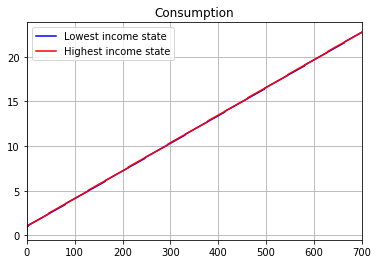

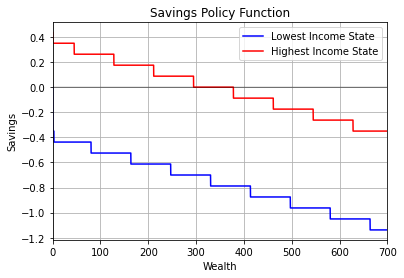

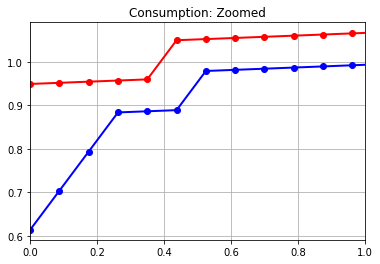

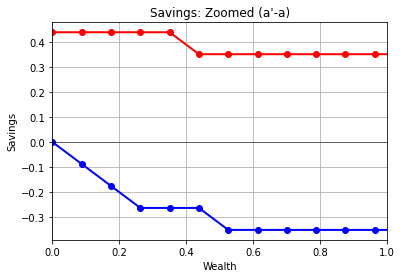

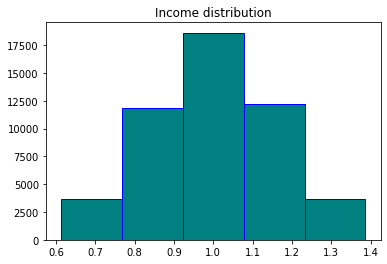

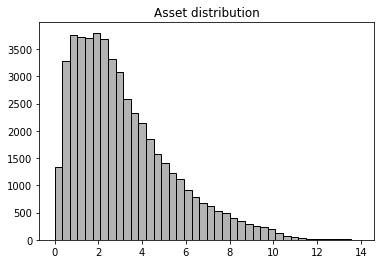

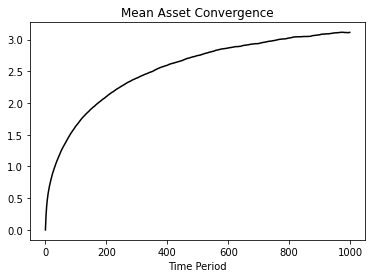

Mean assets: 3.1062427208468115
Fraction borrowing constrained: 0.372%
10th Percentile: 0.6986392602664927
50th Percentile: 2.532567318466036
90th Percentile: 6.287753342398434
99th Percentile: 9.780949643730898


In [24]:
# MAKE PLOTS
if MakePlots==1:
    
    ## consumption policy function
    plt.plot(agrid,con[:,0],'b-',label = 'Lowest income state')
    plt.plot(agrid,con[:,ny-1],'r-', label = 'Highest income state')
    plt.grid()
    plt.xlim((0,amax))
    ### plt.title('Consumption Policy Function')
    plt.title('Consumption')
    plt.legend()
    plt.show()

    ## savings policy function
    plt.plot(agrid,sav[:,0]-agrid[:,0],'b-',label = 'Lowest Income State')
    plt.plot(agrid,sav[:,ny-1]-agrid[:,0],'r-', label = 'Highest Income State')
    plt.plot(agrid,np.zeros((na,1)),'k',linewidth=0.5)
    plt.grid()
    plt.xlim((0,amax))
    plt.xlabel('Wealth')
    plt.ylabel('Savings')
    plt.title('Savings Policy Function')
    #plt.title('Savings')
    plt.legend()
    plt.show()
    
    ## nice zoom
    xlimits = (0,1)
    xlimind = np.ones(na, dtype=bool)
    if np.min(agrid) < xlimits[0]:
        xlimind = np.logical_and(xlimind,(agrid[:,0]>=np.max(agrid[agrid<xlimits[0]])))
    elif np.min(agrid) > xlimits[1]:
        xlimind = 0
    if np.max(agrid) > xlimits[1]:
        xlimind = np.logical_and(xlimind,(agrid[:,0]<=np.min(agrid[agrid>xlimits[1]])))
    elif np.max(agrid) < xlimits[0]:
        xlimind = 0

    ## consumption policy function: zoomed in
    plt.plot(agrid[xlimind],con[xlimind,0],'b-o',linewidth=2)
    plt.plot(agrid[xlimind],con[xlimind,ny-1],'r-o',linewidth=2)
    plt.grid()
    plt.xlim(xlimits)
    plt.title('Consumption: Zoomed')
    plt.show()

    ## savings policy function: zoomed in
    plt.plot(agrid[xlimind],sav[xlimind,0]-agrid[xlimind,0],'b-o',linewidth=2)
    plt.plot(agrid[xlimind],sav[xlimind,ny-1]-agrid[xlimind,0],'r-o',linewidth=2)
    plt.plot(agrid,np.zeros((na,1)),'k',linewidth =0.5)
    plt.grid()
    plt.xlim(xlimits)
    plt.xlabel('Wealth')
    plt.ylabel('Savings')
    plt.title('Savings: Zoomed (a\'-a)')
    plt.show()

    ## income distribution
    plt.hist(ysim[:,Tsim-1],len(ygrid),facecolor=(0,0.5,0.5),edgecolor='blue')
    plt.ylabel('')
    plt.title('Income distribution')
    plt.show()

    ## asset distribution
    plt.hist(asim[:,Tsim-1],40,facecolor=(.7,.7,.7),edgecolor='black')
    plt.ylabel('')
    plt.title('Asset distribution')
    plt.show()

    ## convergence check
    plt.plot(range(0,Tsim),np.mean(asim,0),'k-',linewidth=1.5)
    plt.xlabel('Time Period')
    plt.title('Mean Asset Convergence')
    plt.show()

    ## asset distribution statistics
    aysim = asim[:,Tsim-1]/np.mean(ysim[:,Tsim-1])
    print('Mean assets: ' + str(np.mean(aysim)))
    print('Fraction borrowing constrained: ' + str(np.sum(aysim==borrow_lim)/Nsim * 100) + '%')
    print('10th Percentile: ' + str(np.quantile(aysim,.1)))
    print('50th Percentile: ' + str(np.quantile(aysim,.5)))
    print('90th Percentile: ' + str(np.quantile(aysim,.9)))
    print('99th Percentile: ' + str(np.quantile(aysim,.99)))